## Assessing the influence of the number of sampling steps on the sample quality

In [1]:
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import scipy
import seaborn as sns
import tensorflow as tf
from c2st import c2st
from mmd import maximum_mean_discrepancy
from mpl_toolkits.axes_grid1.inset_locator import mark_inset, zoomed_inset_axes
from tqdm.autonotebook import tqdm
from train import get_setup

from inverse_kinematics import InverseKinematicsModel

2024-05-19 08:34:19.147490: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-19 08:34:19.177684: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-19 08:34:19.177732: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-19 08:34:19.177765: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-19 08:34:19.184338: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-19 08:34:19.185593: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

## Load the performance data

In [2]:
computations_file = "./computations/eval_dict_steps_performance_v2.0.pkl"
tasks = ["gmm", "twomoons", "invkinematics"]
simulation_budgets = [8192]
estimators = ["cmpe"]
sampling_steps = [2, 4, 6, 8, 10, 15, 20, 30, 40, 50]
run_idx = 0

eval_dict = pickle.load(open(computations_file, "rb"))

In [3]:
colors = ["#4477AA", "#EE6677", "#228833", "#CCBB44", "#66CCEE", "#AA3377", "#BBBBBB"]

plot_settings = {
    "ac": {"name": "ACF", "color": colors[0]},
    "nsf": {"name": "NSF", "color": colors[1]},
    "fmpe": {"name": "FMPE", "color": colors[5]},
    "fmpe10": {"name": "FMPE 10#", "color": colors[2]},
    "fmpe30": {"name": "FMPE 30#", "color": colors[4]},
    "cmpe": {"name": "CMPE (Ours)", "color": colors[3]},
    "cmpe10": {"name": "CMPE 10#", "color": colors[3]},
    "cmpe30": {"name": "CMPE 30#", "color": colors[6]},
    "gmm": {"name": "GMM", "color": colors[0]},
    "twomoons": {"name": "Two Moons", "color": colors[1]},
    "invkinematics": {"name": "Inverse Kinematics", "color": colors[2]},
}

## Plot the data

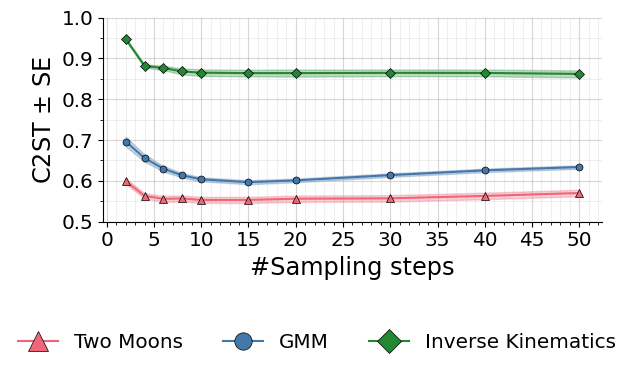

In [4]:
point_kws = {
    "nsf": dict(marker="^", markersize=5, capsize=4, markeredgewidth=0.5, markeredgecolor="black"),
    "ac": dict(marker="D", markersize=4, capsize=3, markeredgewidth=0.5, markeredgecolor="black"),
    "fmpe": dict(marker="V", markersize=5, markeredgecolor="black", markeredgewidth=0.5, capsize=4),
}


line_kws = {
    "gmm": dict(marker="o", linestyle="-", markeredgecolor="black", markeredgewidth=0.5, markersize=5),
    "twomoons": dict(marker="^", linestyle="-", markeredgecolor="black", markeredgewidth=0.5, markersize=6),
    "invkinematics": dict(
        marker="D",
        linestyle="-",
        markeredgecolor="black",
        markeredgewidth=0.5,
        markersize=5,
    ),
}

# less space between subplots
# f, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3), sharey=True, width_ratios=(0.90, 0.10), gridspec_kw={'wspace': 0.15})
f, ax1 = plt.subplots(1, 1, figsize=(6, 3), sharey=True)
tasks = ["twomoons", "gmm", "invkinematics"]
budget = 8192
for ax in [ax1]:
    # CMPE: line with error bars
    for task in tasks:
        cmpe_c2st = [np.mean(eval_dict[task][budget][f"cmpe{step}"]["c2st"]) for step in sampling_steps]
        cmpe_std = [scipy.stats.sem(eval_dict[task][budget][f"cmpe{step}"]["c2st"]) for step in sampling_steps]
        ax.plot(
            sampling_steps,
            cmpe_c2st,
            label=plot_settings[task]["name"],
            color=plot_settings[task]["color"],
            **line_kws[task],
        )
        ax.fill_between(
            sampling_steps,
            np.array(cmpe_c2st) - np.array(cmpe_std) / np.sqrt(1),
            np.array(cmpe_c2st) + np.array(cmpe_std) / np.sqrt(1),
            alpha=0.3,
            color=plot_settings[task]["color"],
        )

    ax.set_ylim(0.50, 1.0)
    # ax.set_title(task)
    # log x axis
    # ax.set_xscale('log')
    # x labels as decimals
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.0f}"))
    # larger tick labels
    ax.tick_params(axis="both", which="major", labelsize="x-large")
    # minor grid every 0.01 units in y and x
    ax.xaxis.set_major_locator(plt.MultipleLocator(5))
    ax.xaxis.set_minor_locator(plt.MultipleLocator(1))
    ax.yaxis.set_minor_locator(plt.MultipleLocator(0.05))
    # 0.01 grid
    ax.grid(which="minor", alpha=0.2, zorder=-1)
    # 0.1 grid
    ax.grid(which="major", alpha=0.5, zorder=-1)
    # ax.set_xlim(0, 1.0)
    ax.grid(zorder=-1, alpha=0.5)
    sns.despine(ax=ax)

ax1.set_xlabel("#Sampling steps", fontsize="xx-large")
ax1.set_ylabel(r"C2ST $\pm$ SE", fontsize="xx-large")

lines, labels = ax1.get_legend_handles_labels()
# lines = [lines[0], lines[1], lines[3], lines[2]]
# labels = [labels[0], labels[1], labels[3], labels[2]]
# legend below plot with 1 row
f.legend(
    lines,
    labels,
    loc="lower center",
    ncol=4,
    bbox_to_anchor=(0.5, -0.25),
    fontsize="x-large",
    frameon=False,
    markerscale=2.5,
)
f.tight_layout()
f.savefig("./figures/steps_performance_c2st.pdf", bbox_inches="tight")